## Plot images of field displaced spin flip scattering

04.02.22

Version 2.0

M.R. Fitzsimmons

For theory see link and references therein:
https://journals.aps.org/prb/abstract/10.1103/PhysRevB.73.134413


User to provide a 4 columns of tab delimited data in form of Qz (recip. Angstroms), R++, R-- and RSF.

User to enter values in the experiment parameters box.  Then run all cells.

LavesPhase.txt is a simulation for one field temperature condition of the experiment described in the reference.

05.02.22

Added slider control of B

May require pip install ipywidgets and possibly pip install widgetsnbextension

In [64]:
%matplotlib inline
%matplotlib notebook

## Experiment parameters

In [65]:
SourceFrequency = 30. # Hz
LambdaBar = 7.5 # middle of wavelength range in Angstroms

TwoTheta0 = 2. # Angle between the direct beam and the specularly reflected beam in degrees

#TwoTheta0 = 4. # Angle between the direct beam and the specularly reflected beam in degrees

B = 4.5 # Applied field in Tesla

BMax = 11 # maximum possible field in Tesla

MaxwellianTail = True # Set this option to true to account for Lambda^-5 tail of Maxwellian Spectrum

#MaxwellianTail = False # Set this option to true to account for Lambda^-5 tail of Maxwellian Spectrum

#filename = 'Qsimulation.txt' # File of R(Q) data for two NSF cross-sections and one SF cross-section

filename = 'LavesPhase.txt' # File of R(Q) data for two NSF cross-sections and one SF cross-section



## Import modules

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.widgets import Slider, Button
from matplotlib.widgets import CheckButtons

import pandas as pd

Pi = np.pi
RadD = 180. / Pi

# function obtained from 
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
# and modified to return the index (idx) and array value (array[idx]) closes to the target.
def find_nearest(array, target):
    array = np.asarray(array)
    idx = (np.abs(array - target)).argmin()
    return array[idx],idx


## Get the R(Q) simulation data

Assuming 4 columns of tab-delimited data representing Q, R++, R--, RSF

<IPython.core.display.Javascript object>


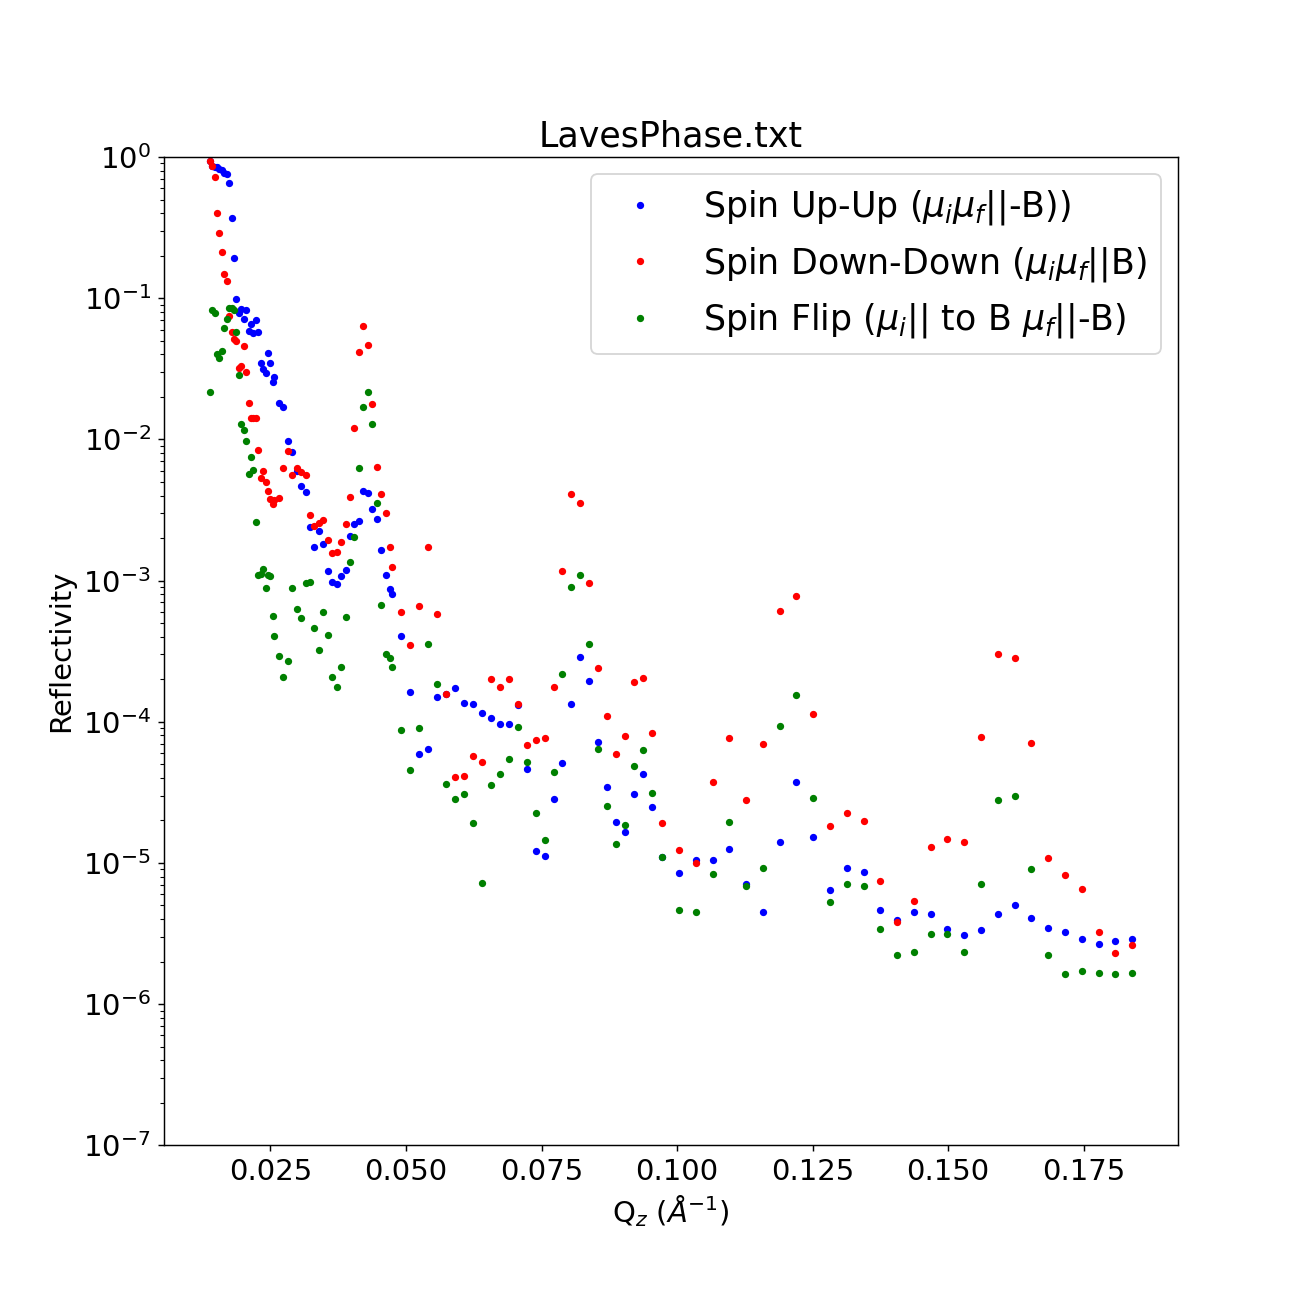

In [67]:
df = pd.read_csv(filename, sep='\t')
RofQ = df.to_numpy()

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize = (10,10))
plt.title(filename)
plt.xlabel('Q$_z$ ($\AA$$^{-1}$)')
plt.ylabel('Reflectivity')

plt.yscale('log')
plt.ylim(1.e-7,1.)

ax.plot(RofQ[:,0],RofQ[:,1],'bo',markersize='3',label='Spin Up-Up ($\mu_i\mu_f$||-B))')
ax.plot(RofQ[:,0],RofQ[:,2],'ro',markersize='3',label='Spin Down-Down ($\mu_i\mu_f$||B)')
ax.plot(RofQ[:,0],RofQ[:,3],'go',markersize='3',label='Spin Flip ($\mu_i$|| to B $\mu_f$||-B)')
legend = ax.legend(loc='upper right', fontsize='large')
plt.show()


## Source parameters

In [68]:
SourceToDetectorDistance = 20. # meters
TBins = 250 # number of tof bins to use to split band = 1/SourceFrequency
DetectorPixels = 304 # number of detector pixels along the direction of Qz

ToFLambdaBar = SourceToDetectorDistance * LambdaBar / 3956. #time of flight of lambdabar
ToFMin, ToFMax = ToFLambdaBar - 0.5 / SourceFrequency, ToFLambdaBar + 0.5 / SourceFrequency
ToF = np.linspace(ToFMin,ToFMax,TBins) # array of times-of-flight in seconds
Lambda = 3956. * ToF / SourceToDetectorDistance


## Instrument parameters

In [69]:
DBins = 304 # Number of detector pixels measuring scattering angle
PixelToDegree = 1. / 2000. * RadD # Assumes 1mm wide pixel and sample to detector distance of 2000 mm
TwoTheta = np.linspace(TwoTheta0 - DBins/2*PixelToDegree,TwoTheta0 + DBins/2*PixelToDegree,DBins) #array of angles in degrees
TwoThetaMin, TwoThetaMax = np.min(TwoTheta), np.max(TwoTheta)

DeltaTwoTheta = 0.25 # Width of the specular reflection in degrees as seen in the detector
DeltaBin = int(DeltaTwoTheta / PixelToDegree + 0.5)


## Function that calculates the 4 cross-sections in tof vs angle space from a simulation

In [70]:
def f(ToF, TwoTheta, Lambda, RofQ, MaxwellianTail, B):
    Pi = np.pi
    RadD = 180. / Pi

    TBins = len(ToF)
    DBins = len(TwoTheta)
    
    Mask = np.full((TBins,DBins), False, dtype=bool)
    Mask[:,int(DBins/2-DeltaBin/2+0.5):int(DBins/2+DeltaBin/2+0.5)] = True
    QBins = np.zeros((TBins,DBins), dtype=np.float32)
    for i in range(TBins):
        for j in range(DBins):
            if Mask[i,j]==True:
                QBins[i,j] = 4. * Pi * np.sin(TwoTheta[j]/RadD) / Lambda[i]

    RPP = np.zeros((TBins,DBins), dtype=np.float32) # PP or UU state
    RPP[Mask] = np.interp(QBins[Mask],RofQ[:,0],RofQ[:,1])

    RMM = np.zeros((TBins,DBins), dtype=np.float32) # MM or DD state
    RMM[Mask] = np.interp(QBins[Mask],RofQ[:,0],RofQ[:,2])

    RSF = np.zeros((TBins,DBins), dtype=np.float32) # SF state
    RSF[Mask] = np.interp(QBins[Mask],RofQ[:,0],RofQ[:,3])

    # Now compute the location of the field displace SF scattering for the +- and -+ states

    RPM = np.zeros((TBins,DBins), dtype=np.float32) # P to M SF state
    RMP = np.zeros((TBins,DBins), dtype=np.float32) # M to P SF state

    for i in range(TBins):
        for j in range(DBins):
            if Mask[i,j]==True:
                H = B * 10. # convert B to H in kOe
                Alpha = TwoTheta[j] / 2. / RadD

                Beta = np.sqrt(Alpha**2 + 1.47e-7*H*Lambda[i]**2)
                TwoThetaFieldDisplaced = (Alpha + Beta)*RadD
                TwoThetaActual, jdx = find_nearest(TwoTheta, TwoThetaFieldDisplaced)
                RPM[i,jdx] = RSF[i,j] + RPM[i,jdx]

                BetaSquare = Alpha**2 - 1.47e-7*H*Lambda[i]**2
                if BetaSquare >= 0.:
                    Beta = np.sqrt(Alpha**2 - 1.47e-7*H*Lambda[i]**2)
                    TwoThetaFieldDisplaced = (Alpha + Beta)*RadD
                    TwoThetaActual, jdx = find_nearest(TwoTheta, TwoThetaFieldDisplaced)
                    RMP[i,jdx] = RSF[i,j] + RMP[i,jdx]

    if MaxwellianTail:
        SF = (ToF / ToF[0])**5
        for j in range(DBins):
            RPP[:,j] = RPP[:,j]/SF
            RPM[:,j] = RPM[:,j]/SF
            RMP[:,j] = RMP[:,j]/SF
            RMM[:,j] = RMM[:,j]/SF
                    
    return RPP+RPM,RMP+RMM

## Calculate the images for the two NSF cross-sections

<IPython.core.display.Javascript object>


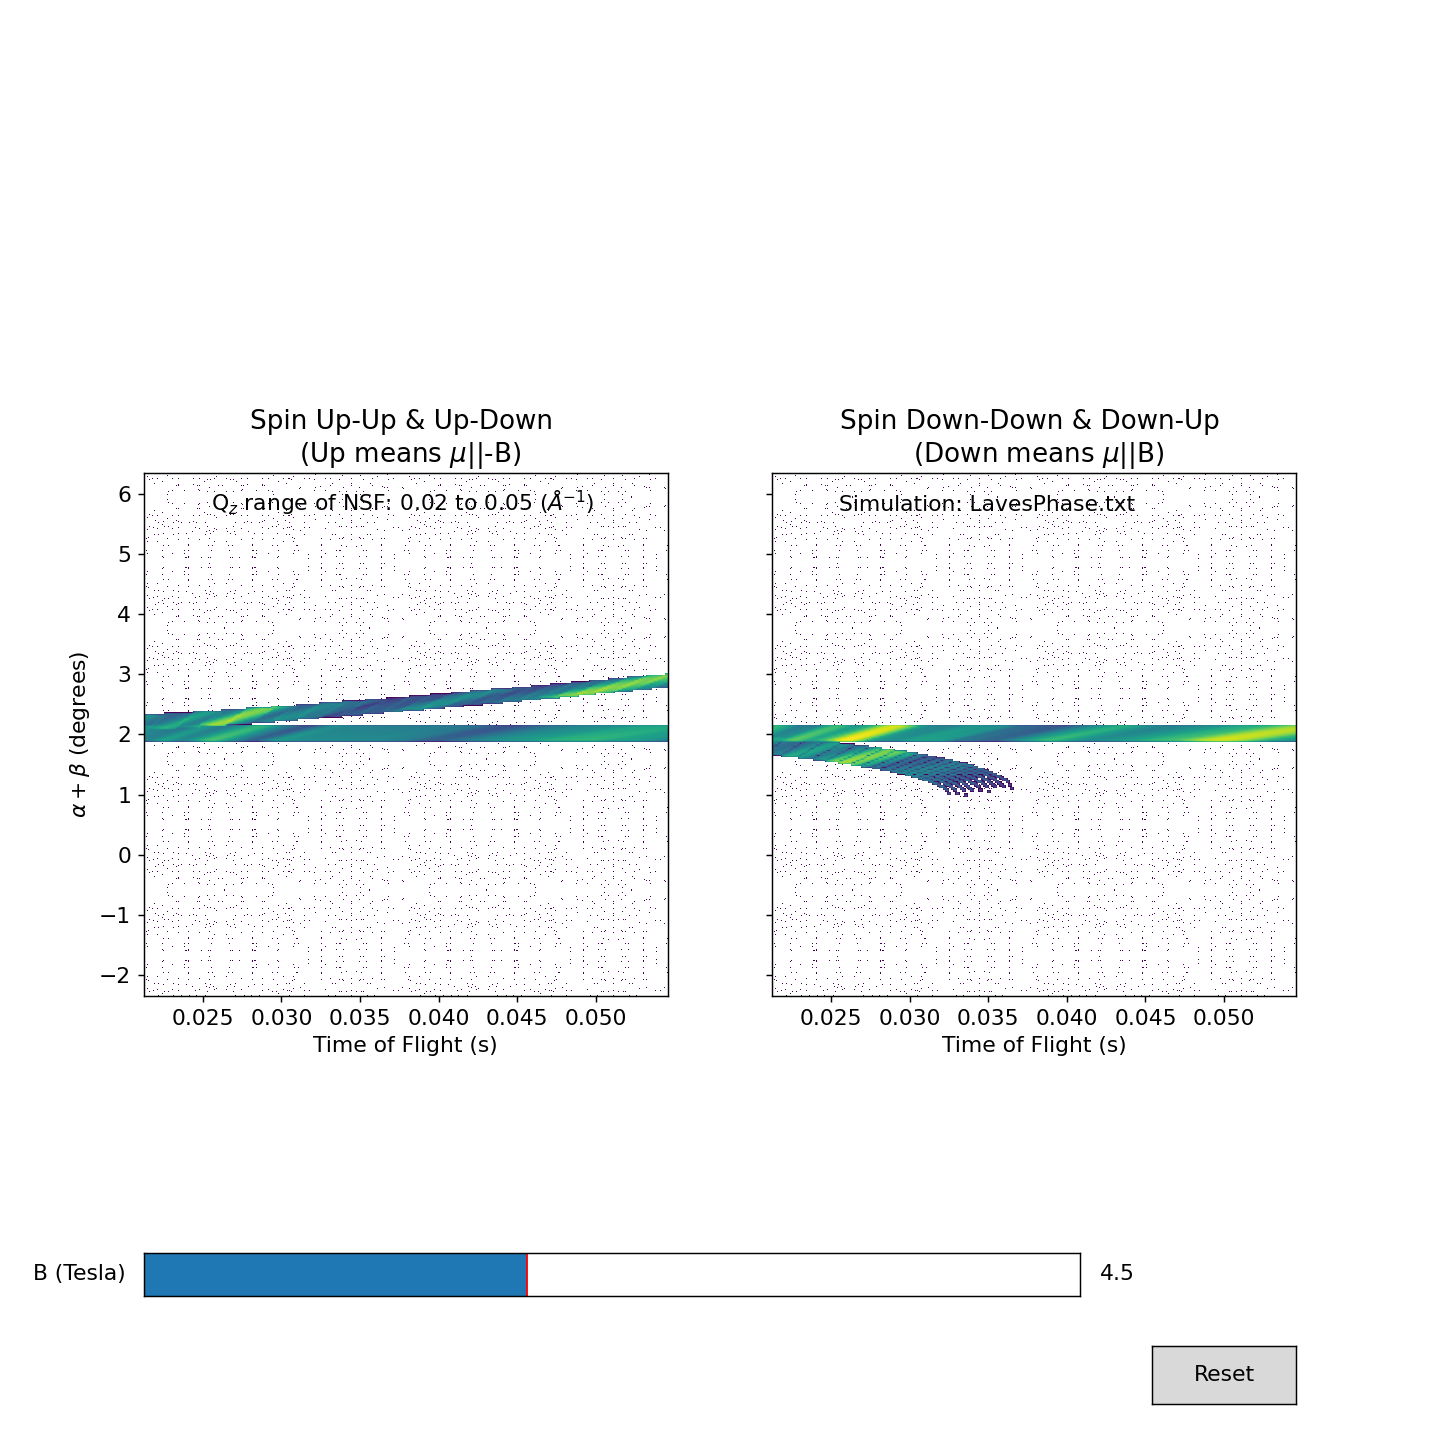

In [71]:
# calculate first image to define min and max range for intensity plot
AllImage = f(ToF, TwoTheta, Lambda, RofQ, MaxwellianTail, B)

QMin, QMax = 4*Pi*np.sin(TwoTheta0/RadD/2)/np.max(Lambda),4*Pi*np.sin(TwoTheta0/RadD/2)/np.min(Lambda)

Image1, Image2 = AllImage[0], AllImage[1]

ImageMax = np.max([Image1,Image2])
ImageMin = np.max([ImageMax *1e-4,1e-7])

plt.rcParams.update({'font.size': 12})

# Create the figure and the line that we will manipulate

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (11,11))
ax1.set_xlabel('Time of Flight (s)')
#ax1.set_ylabel('Two Theta (degrees)')
ax1.set_ylabel(r'$\alpha + \beta$ (degrees)')
ax1.set_title('Spin Up-Up & Up-Down \n (Up means $\mu$||-B)')

ax2.set_xlabel('Time of Flight (s)')
#ax2.set_ylabel('Two Theta (degrees)')
ax2.set_title('Spin Down-Down & Down-Up \n (Down means $\mu$||B)')

image1 = ax1.imshow(np.transpose(f(ToF, TwoTheta, Lambda, RofQ, MaxwellianTail, B)[0],axes=[1,0]), extent=[ToFMin,ToFMax,TwoThetaMin,TwoThetaMax], aspect=1/((TwoThetaMax-TwoThetaMin)/(ToFMax-ToFMin)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=ImageMin, vmax=ImageMax))
image2 = ax2.imshow(np.transpose(f(ToF, TwoTheta, Lambda, RofQ, MaxwellianTail, B)[1],axes=[1,0]), extent=[ToFMin,ToFMax,TwoThetaMin,TwoThetaMax], aspect=1/((TwoThetaMax-TwoThetaMin)/(ToFMax-ToFMin)), origin='lower',interpolation='bilinear', cmap=cm.viridis, norm=LogNorm(vmin=ImageMin, vmax=ImageMax))

ax1.text(1.2*np.min(ToF), 0.9*np.max(TwoTheta), 'Q$_{z}$ range of NSF: %.2f to %.2f ($\AA$$^{-1}$)'%(QMin,QMax))
ax2.text(1.2*np.min(ToF), 0.9*np.max(TwoTheta), 'Simulation: %s'%filename)

#fig.colorbar(image2, ax = ax2, shrink=0.1)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.1, bottom=0.1)

# Make a horizontal slider to control the Field.
axB = plt.axes([0.1, 0.1, 0.65, 0.03])
B_slider = Slider(
    ax=axB,
    label='B (Tesla)',
    valmin=0,
    valmax=BMax,
    valinit=B,
)



# The function to be called anytime a slider's value changes
def update(val):
    image1.set_data(np.transpose(f(ToF, TwoTheta, Lambda, RofQ, MaxwellianTail, B_slider.val)[0],axes=[1,0]))
    image2.set_data(np.transpose(f(ToF, TwoTheta, Lambda, RofQ, MaxwellianTail, B_slider.val)[1],axes=[1,0]))
    fig.canvas.draw_idle()
    
# register the update function with each slider
B_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    B_slider.reset()

button.on_clicked(reset)

plt.show()